In [57]:
import torch
from models import GridMLMMelHarm
from GridMLM_tokenizers import CSGridMLMTokenizer
from data_utils import CSGridMLMDataset, CSGridMLM_collate_fn
from torch.utils.data import DataLoader
from train_utils import apply_structured_masking

In [58]:
batchsize = 1
val_dir = '/media/maindisk/maximos/data/hooktheory_all12_train'
tokenizer = CSGridMLMTokenizer(fixed_length=256)
val_dataset = CSGridMLMDataset(val_dir, tokenizer, 512)
valloader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False, collate_fn=CSGridMLM_collate_fn)

In [59]:
mask_token_id = tokenizer.mask_token_id
stage = 0
curriculum_type = 'ts_incr'
# curriculum_type = 'random'
curriculum_progression = 'uniform'
stage_aware = True

In [60]:
device_name = 'cuda:1'
if device_name == 'cpu':
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device(device_name)
    else:
        print('Selected device not available: ' + device_name)
model = GridMLMMelHarm(
    chord_vocab_size=len(tokenizer.vocab),
    conditioning_dim=16,
    device=device,
    max_stages=6
)
model_path = 'saved_models/' + curriculum_progression + '/' + 'a_'*stage_aware + curriculum_type +  '.pt'
checkpoint = torch.load(model_path, map_location=device_name, weights_only=True)
model.load_state_dict(checkpoint)
model.eval()
model.to(device)

GridMLMMelHarm(
  (condition_proj): Linear(in_features=16, out_features=512, bias=True)
  (melody_proj): Linear(in_features=100, out_features=512, bias=True)
  (harmony_embedding): Embedding(354, 512)
  (dropout): Dropout(p=0.3, inplace=False)
  (stage_embedding): Embedding(6, 64)
  (stage_proj): Linear(in_features=576, out_features=512, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (d

In [61]:
model.harmony_embedding.weight.shape

torch.Size([354, 512])

In [62]:
i = 0
for batch in valloader:
    if i == 3:
        break
    i += 1

In [63]:
melody_grid = batch["pianoroll"].to(device)           # (B, 256, 140)
harmony_gt = batch["input_ids"].to(device)         # (B, 256)
conditioning_vec = batch["time_signature"].to(device)  # (B, C0)

In [64]:
# Apply masking to harmony
harmony_input, harmony_target = apply_structured_masking(
    harmony_gt,
    mask_token_id,
    stage,
    conditioning_vec,
    curriculum_type
)

In [65]:
logits = model(
    conditioning_vec.to(device),
    melody_grid.to(device),
    harmony_input.to(device),
    None if not stage_aware else stage
)

In [66]:
print(logits.shape)

torch.Size([1, 256, 354])


In [67]:
output_ids = torch.argmax(logits, dim=-1)

output_tokens = []
for i,t in enumerate(output_ids[0].tolist()):
    output_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
print('output_tokens')
print(output_tokens)

harmony_input_tokens = []
for i,t in enumerate(harmony_input[0].tolist()):
    harmony_input_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
    # if tokenizer.ids_to_tokens[t] != '<mask>':
    #     print('UNMASK:', i)
print('harmony_input_tokens')
print(harmony_input_tokens)

harmony_target_tokens = []
for i,t in enumerate(harmony_target[0].tolist()):
    if t < 0:
        harmony_target_tokens.append( str(i) + ':' + '<mask>' )
    else:
        harmony_target_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
print('harmony_target_tokens')
print(harmony_target_tokens)

harmony_gt_tokens = []
for i,t in enumerate(harmony_gt[0].tolist()):
    harmony_gt_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
print('harmony_gt_tokens')
print(harmony_gt_tokens)

output_tokens
['0:C:7', '1:C:7', '2:C:7', '3:G:hdim7', '4:C:7', '5:C:7', '6:C:7', '7:G:7', '8:C:7', '9:G:7', '10:C:7', '11:C:7', '12:G:7', '13:C:7', '14:C:7', '15:C:7', '16:C:7', '17:C:7', '18:G:7', '19:C:7', '20:G:7', '21:C:7', '22:G:7', '23:C:7', '24:G:7', '25:C:7', '26:C:7', '27:G:7', '28:F:maj7', '29:C:7', '30:C:7', '31:C:7', '32:C:7', '33:C:7', '34:C:7', '35:C:7', '36:C:7', '37:C:7', '38:F:maj7', '39:F:maj7', '40:C:7', '41:G:7', '42:G:7', '43:C:7', '44:G:7', '45:C:7', '46:C:7', '47:C:7', '48:C:7', '49:F:maj7', '50:F:maj7', '51:C:7', '52:C:7', '53:G:7', '54:C:7', '55:C:7', '56:C:7', '57:G:hdim7', '58:C:7', '59:G:7', '60:C:7', '61:C:7', '62:C:7', '63:F#:dim', '64:C:7', '65:C:7', '66:C:7', '67:C:7', '68:G:7', '69:C:7', '70:G:7', '71:C:maj', '72:C:7', '73:C:7', '74:C:7', '75:G:7', '76:G:hdim7', '77:C:7', '78:C:7', '79:G:7', '80:C:7', '81:C:7', '82:C:7', '83:F:maj7', '84:F:maj7', '85:C:7', '86:G:hdim7', '87:C:7', '88:C:7', '89:C:7', '90:C:7', '91:C:7', '92:C:7', '93:C:7', '94:C:7', '95

In [68]:
import matplotlib.pyplot as plt

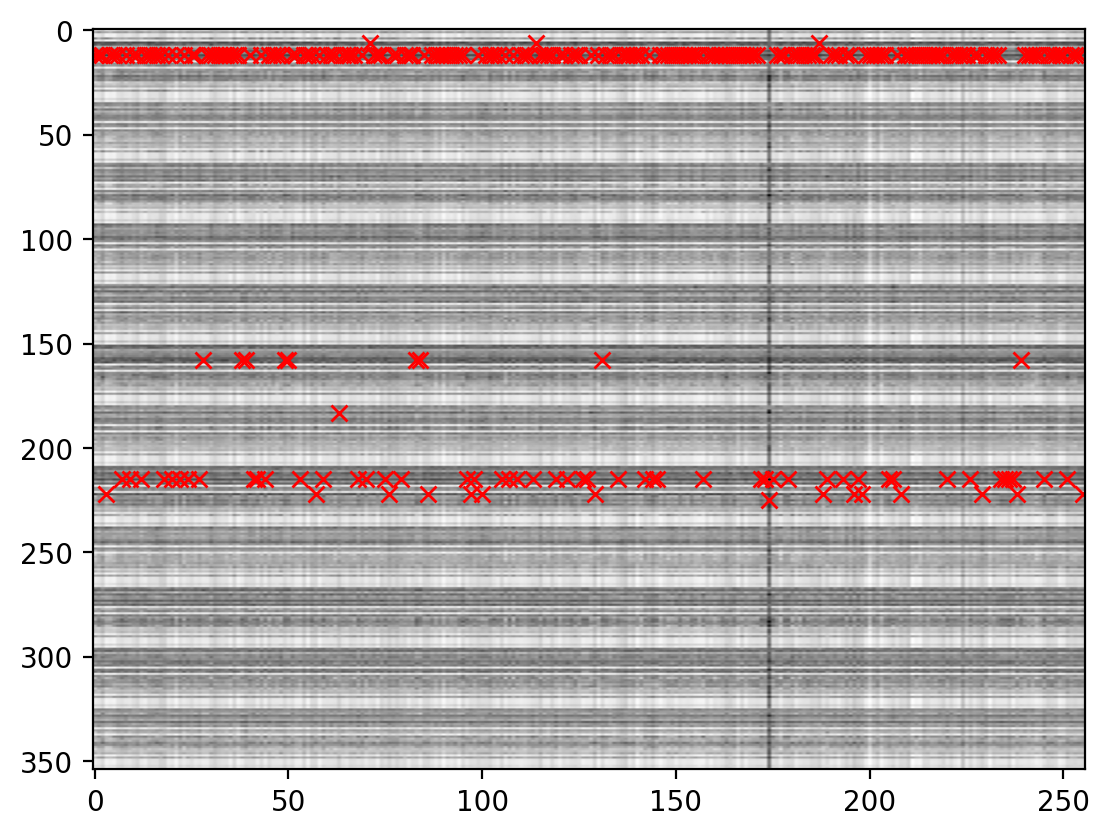

In [69]:
plt.imshow(logits[0,:,:].detach().cpu().numpy().T, aspect='auto', cmap='gray_r',)
plt.plot(output_ids.detach().cpu().numpy().T, 'rx')

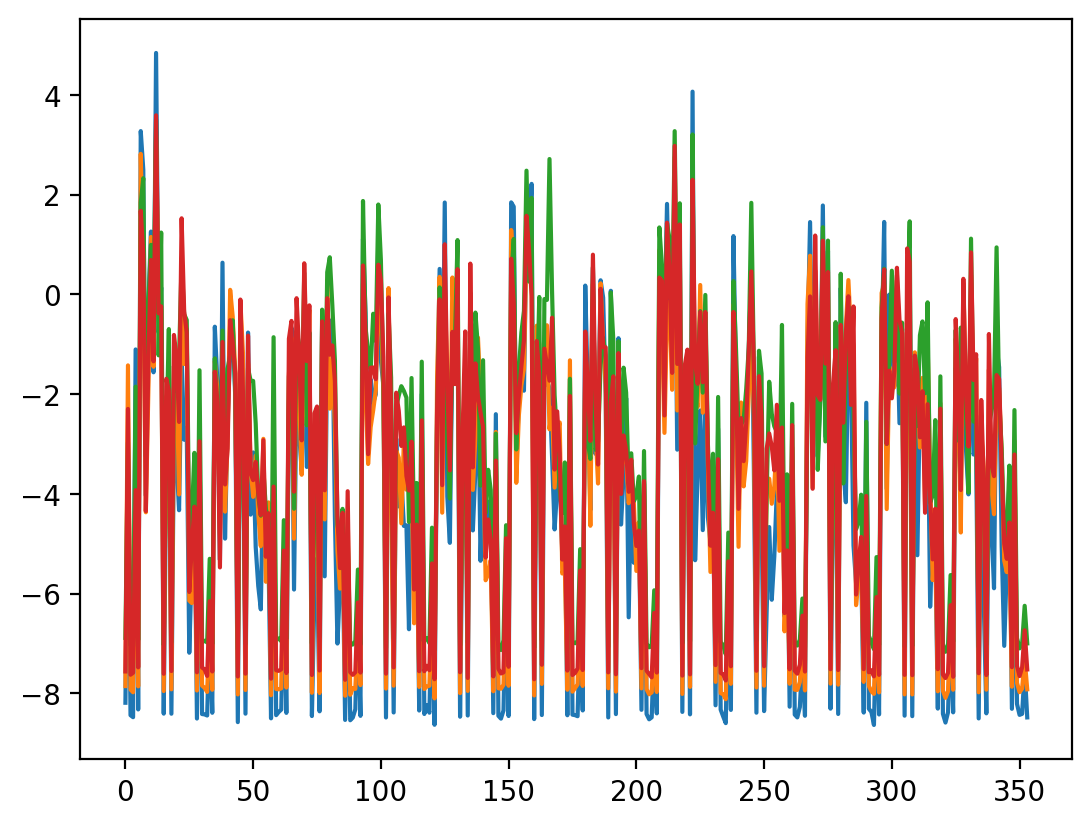

In [70]:
plt.plot(logits[0,0,:].detach().cpu().numpy())
plt.plot(logits[0,1,:].detach().cpu().numpy())
plt.plot(logits[0,2,:].detach().cpu().numpy())
plt.plot(logits[0,6,:].detach().cpu().numpy())

In [71]:
x = logits[0,0,:].argsort(descending=True)
for i in x:
    print( tokenizer.ids_to_tokens[int(i)])

C:7
G:hdim7
C:maj
C:min
F:min7
F:maj
G:7
E:dim
G:dim
A:7
F:min
A#:min
A:min
C:sus4
F:7
D#:7
G#:maj
D#:maj
G:min7
F:maj7
A:min7
A#:min6
C#:dim
F#:dim
E:min
G:maj
G#:maj7
F#:7
A:dim
F#:maj
C:min7
A:hdim7
F#:maj6
A#:dim
G:min
B:7
F#:maj7
C:dim
E:min7
D#:min
E:hdim7
D:hdim7
D:min11
A#:7
B:dim
G:sus4
C#:maj7
D:7
C#:maj
D:min
A#:min7
G:sus2
C:maj7
C#:hdim7
G:aug
F#:hdim7
E:7
A:maj
A:9
D#:maj6
A#:sus4
D:min9
A#:maj6
D:9
B:9
<nc>
E:maj7
G#:7
C#:7
A#:maj
C:9
G#:maj6
C#:maj6
D:min7
D#:maj7
F:min6
B:min11
A#:hdim7
B:maj
F:sus4
E:9
C:sus2
A:min11
E:min6
C:min6
C#:min6
G#:min
F:5
D#:dim
F:maj9
C#:min
D:dim
A#:sus2
D#:min7
F:hdim7
F:min9
A#:11
F:sus2
F#:min
F#:min7
D#:5
D#:sus2
A:sus2
A#:min9
C#:min7
F#:9
F:dim
D#:sus4
A:5
G:maj6
D:maj
G:11
F:maj6
E:maj
A:aug
F#:min6
A:min6
A#:9
G:9
E:5
G#:maj13
G:min6
D#:min6
G#:dim
C#:sus2
A#:maj7
D#:maj13
B:min
C:11
G:5
C#:5
C:hdim7
D:sus4
C:5
F#:sus2
A:maj7
A#:5
G#:sus2
D#:hdim7
G#:sus4
C:min11
D#:aug
B:min7
E:aug
B:sus4
G:maj7
C#:min9
F#:sus4
A#:min11
B:maj7
F:

In [72]:
from generate_utils import ts_iterative_unmasking

In [73]:
output_ids = ts_iterative_unmasking(
        model,
        conditioning_vec,
        melody_grid,
        stage_aware,
        mask_token_id,
        num_stages=6
    )

In [74]:
output_tokens = []
for i,t in enumerate(output_ids[0].tolist()):
    output_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
print('output_tokens')
print(output_tokens)

harmony_input_tokens = []
for i,t in enumerate(harmony_input[0].tolist()):
    harmony_input_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
    # if tokenizer.ids_to_tokens[t] != '<mask>':
    #     print('UNMASK:', i)
print('harmony_input_tokens')
print(harmony_input_tokens)

harmony_target_tokens = []
for i,t in enumerate(harmony_target[0].tolist()):
    if t < 0:
        harmony_target_tokens.append( str(i) + ':' + '<mask>' )
    else:
        harmony_target_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
print('harmony_target_tokens')
print(harmony_target_tokens)

harmony_gt_tokens = []
for i,t in enumerate(harmony_gt[0].tolist()):
    harmony_gt_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
print('harmony_gt_tokens')
print(harmony_gt_tokens)

output_tokens
['0:C:7', '1:G:hdim7', '2:G:hdim7', '3:G:hdim7', '4:G:hdim7', '5:C:7', '6:G:hdim7', '7:E:hdim7', '8:C:7', '9:G:hdim7', '10:G:hdim7', '11:C:7', '12:C#:7', '13:C:7', '14:G:hdim7', '15:G:hdim7', '16:D#:7', '17:G:hdim7', '18:G:hdim7', '19:G:hdim7', '20:G:hdim7', '21:C:7', '22:G:hdim7', '23:C:7', '24:G:hdim7', '25:C:7', '26:C:7', '27:C:7', '28:C:7', '29:C:7', '30:G:hdim7', '31:G:hdim7', '32:C:7', '33:C:7', '34:C:7', '35:C:7', '36:C:7', '37:C:7', '38:C:7', '39:C:7', '40:G:hdim7', '41:G:hdim7', '42:G:hdim7', '43:G:hdim7', '44:C:7', '45:G:hdim7', '46:G:hdim7', '47:C:7', '48:C:7', '49:C:7', '50:C:7', '51:G:hdim7', '52:G:hdim7', '53:G:hdim7', '54:G:hdim7', '55:C:7', '56:C:7', '57:G:hdim7', '58:G:hdim7', '59:C:7', '60:G:hdim7', '61:C:7', '62:G:hdim7', '63:G:min6', '64:C:7', '65:C:7', '66:G:hdim7', '67:G:hdim7', '68:C:7', '69:G:hdim7', '70:G:min7', '71:G:hdim7', '72:G:hdim7', '73:C:7', '74:C:7', '75:G:hdim7', '76:G:hdim7', '77:G:hdim7', '78:G:hdim7', '79:G:hdim7', '80:C:7', '81:G:hdi